## __APPSTAT_02. <br>Простейшие случайные величины__
***

In [9]:
from itertools import product, combinations_with_replacement
from operator import add, mul
from fractions import Fraction
from statistics import covariance, correlation
from random import choice
from math import factorial
from sympy.stats import Die, FiniteRV, density, E, variance
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import binom
from scipy.integrate import quad
import matplotlib.pyplot as plt
import seaborn as sns

### __Совместное распределение случайных величин__

Сквозной пример данной лекции - эксперимент двукратного бросания правильного тетраэдра, в вершинах которого написаны числа 1, 2, 3, 4. Пространство элементарных исходов состоит из 16 равновозможных исходов, означающих, что при первом бросании выпало число $i$, а при втором - $j$. Тогда __`x`__ в __`numpy`__ (__`X`__ в __`sympy`__) - случайная величина, обозначающая сумму выпавших очков, __`y`__ в __`numpy`__ (__`Y`__ в __`sympy`__) - случайная величина, обозначающая произведение выпавших очков. 
<br>В __`sympy`__ реализуем это двумя одинаковыми условными тетраэдрами - объектами класса __`Die`__ (игральная кость, мн. ч. _dice_) библиотеки __`sympy`__. В __`numpy`__ - суммированием и умножением элементов пар из итератора __`product`__ модуля __`itertools`__ стандартной библиотеки.

In [4]:
# инициализация тетраэдров 
n = 4
t1, t2 = Die('t1', n), Die('t2', n)

In [119]:
# распределение случайной величины X
X = FiniteRV('X', density(t1+t2))
dX = density(X).dict
dX

{2: 1/16, 3: 1/8, 4: 3/16, 5: 1/4, 6: 3/16, 7: 1/8, 8: 1/16}

In [120]:
# распределение случайной величины Y
Y = FiniteRV('Y', density(t1*t2))
dY = density(Y).dict
dY

{1: 1/16, 2: 1/8, 3: 1/8, 4: 3/16, 6: 1/8, 8: 1/8, 9: 1/16, 12: 1/8, 16: 1/16}

In [121]:
# составим совместное распределение X и Y

holder = []

for x, y in product(dX.keys(), dY.keys()):
    counter = 0
    for i, j in combinations_with_replacement(range(1, n+1), 2):
        if i + j == x and i * j == y:
            if i == j:
                counter += 1
            else:
                counter += 2  # если пара (i,j) OK, где i!=j, то (j,i) также OK 
    holder.append(counter)

X_Y = np.array(holder).reshape(len(dX), len(dY)) / n**2
df = pd.DataFrame(X_Y, index=dX.keys(), columns=dY.keys())
df  # значения X - по вертикали, Y - по горизонтали

,1,2,3,4,6,8,9,12,16
2,0.0625,0.000,0.000,0.0000,0.000,0.000,0.0000,0.000,0.0000
3,0.0000,0.125,0.000,0.0000,0.000,0.000,0.0000,0.000,0.0000
4,0.0000,0.000,0.125,0.0625,0.000,0.000,0.0000,0.000,0.0000
5,0.0000,0.000,0.000,0.1250,0.125,0.000,0.0000,0.000,0.0000
6,0.0000,0.000,0.000,0.0000,0.000,0.125,0.0625,0.000,0.0000
7,0.0000,0.000,0.000,0.0000,0.000,0.000,0.0000,0.125,0.0000
8,0.0000,0.000,0.000,0.0000,0.000,0.000,0.0000,0.000,0.0625


In [122]:
# маргинальное (одномерное) распределение X
# axis=1 - операция _вдоль_ горизонтальной оси 
df.sum(axis=1)

2    0.0625
3    0.1250
4    0.1875
5    0.2500
6    0.1875
7    0.1250
8    0.0625
dtype: float64

In [123]:
# маргинальное (одномерное) распределение Y
# axis=0 - операция _вдоль_ вертикальной оси
# в pandas axis=0 - параметр по умолчанию 
df.sum()

1     0.0625
2     0.1250
3     0.1250
4     0.1875
6     0.1250
8     0.1250
9     0.0625
12    0.1250
16    0.0625
dtype: float64

In [124]:
# в numpy, в отличие от pandas, 
# суммирование без указания оси даст результат по всему массиву (2D в данном сл.)
X_Y.sum()

1.0

In [125]:
# укажем ось явно
# маргинальное (одномерное) распределение X
X_Y.sum(axis=1)

array([0.0625, 0.125 , 0.1875, 0.25  , 0.1875, 0.125 , 0.0625])

In [126]:
# укажем ось явно
# маргинальное (одномерное) распределение Y
X_Y.sum(axis=0)

array([0.0625, 0.125 , 0.125 , 0.1875, 0.125 , 0.125 , 0.0625, 0.125 ,
       0.0625])

In [127]:
# альтернативный способ вытягивания маргинального распределения X,
# читается: распределение X при условии Y (при данных значениях Y)
density(X, Y).dict

{2: 1/16, 3: 1/8, 4: 3/16, 5: 1/4, 6: 3/16, 7: 1/8, 8: 1/16}

In [128]:
# альтернативный способ вытягивания маргинального распределения Y,
# читается: распределение Y при условии X (при данных значениях X)
density(Y, X).dict

{1: 1/16, 2: 1/8, 3: 1/8, 4: 3/16, 6: 1/8, 8: 1/8, 9: 1/16, 12: 1/8, 16: 1/16}

Получим те же распределения в __`numpy`__. Обратите внимание на параметр __`return_counts`__ у [__`numpy.unique`__](https://numpy.org/doc/stable/reference/generated/numpy.unique.html).

In [5]:
x_orig = []
y_orig = []

for pair in product(range(1, n+1), range(1, n+1)):
    x_orig.append(add(*pair))
    y_orig.append(mul(*pair))
    
x, Px = np.unique(x_orig, return_counts=True)
y, Py = np.unique(y_orig, return_counts=True)
Px, Py = map(lambda p: p / n**2, (Px, Py))

In [6]:
# значения случайной величины x (аналог X для sympy), сумма очков
x  # array([2, 3, 4, 5, 6, 7, 8])

array([2, 3, 4, 5, 6, 7, 8])

In [131]:
# соответствующие вероятности исходов x
Px

array([0.0625, 0.125 , 0.1875, 0.25  , 0.1875, 0.125 , 0.0625])

In [7]:
# значения случайной величины y (аналог Y для sympy), произведение очков
y  # array([ 1,  2,  3,  4,  6,  8,  9, 12, 16])

array([ 1,  2,  3,  4,  6,  8,  9, 12, 16])

In [133]:
# соответствующие вероятности исходов y
Py

array([0.0625, 0.125 , 0.125 , 0.1875, 0.125 , 0.125 , 0.0625, 0.125 ,
       0.0625])

***
### __Медиана__

Медиана в __`numpy`__ определена как центральный элемент сортированного массива при нечетном количестве элементов и полусумма центральной пары - при четном.

In [134]:
x  # array([2, 3, 4, 5, 6, 7, 8])

array([2, 3, 4, 5, 6, 7, 8])

In [135]:
np.median(x)  # 5.0

5.0

In [136]:
arr = np.array([-4, -2, 0, 3, 4, 6, 7, 9])
np.median(arr)  # 3.5

3.5

Другую стратегию работы с медианой можно выбрать, если вспомнить, что медиана это 50-ый процентиль и посмотреть на параметры [__`numpy.percentile`__](https://numpy.org/doc/stable/reference/generated/numpy.percentile#numpy-percentile):

In [137]:
for method in 'lower', 'higher', 'midpoint', 'nearest':
    print(f'{method}: {np.percentile(arr, 50, method=method)}')
    
# lower: 3
# higher: 4
# midpoint: 3.5
# nearest: 4

lower: 3
higher: 4
midpoint: 3.5
nearest: 4


Второй вариант - отдельные функции __`median`__, __`median_low`__, __`median_high`__, __`median_grouped`__ из модуля [__`statistics`__](https://docs.python.org/3/library/statistics.html) стандартной библиотеки. 

***
### __Математическое ожидание__

Если все $n$ значений случайной величины равновозможны, то есть их вероятности равны $\frac{1}{n}$, то математическое ожидание становится средним арифметическим:
$\mathbb{E}X=x_{1}p_{1}+x_{2}p_{2}+...+x_{n}p_{n}=x_{1}p+x_{2}p+...+x_{n}p=p(x_{1}+x_{2}+...+x_{n})=\frac{1}{n}\sum_{i=1}^{n}x_{i}=\overline x$. В этом случае работает метод массива [__`numpy.ndarray.mean`__](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.mean.html) или его функциональный эквивалент [__`numpy.mean`__](https://numpy.org/doc/stable/reference/generated/numpy.mean.html):

In [138]:
# математическое ожидание выпавших очков на правильной игральной кости
np.arange(1, 7).mean()  # 3.5

3.5

In [139]:
# то же, sympy
D = Die('D', 6)
E(D)  # 7/2

7/2

Если значения случайной величины не равновозможны, удобно использовать матричное произведение [__`numpy.matmul`__](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html#numpy-matmul) и его короткую запись _at_, __`@`__:

In [140]:
# математическое ожидание x, numpy
# "сумма произведений соответствующих координат"
x @ Px  # 5.0

5.0

In [141]:
# математическое ожидание X (аналог x), sympy
E(X)  # 5

5

In [142]:
# математическое ожидание y, numpy
y @ Py  # 6.25

6.25

In [143]:
# математическое ожидание Y (аналог y), sympy
E(Y).evalf()  # 6.25

6.25000000000000

In [144]:
# математическое ожидание случайной величины 3*X + 4*Y, sympy
E(3*X + 4*Y)  # 40

40

In [145]:
# случайная величина X*Y
XY = FiniteRV('XY', density(t1*t2 * (t1+t2)))
density(XY).dict

{2: 1/16, 6: 1/8, 12: 1/8, 16: 1/16, 20: 1/8, 30: 1/8, 48: 1/8, 54: 1/16, 84: 1/8, 128: 1/16}

Обратите внимание на то, что перемножаются не сами случайные величины, а их "плотности": _pmf_, _probability mass function_, или функция вероятности для дискретных случайных величин, и _pdf_, _probability density function_, или плотность вероятности (плотность распределения) - для непрерывных.

In [146]:
# математическое ожидание случайной величины X*Y
E(XY).evalf()  # 37.5

37.5000000000000

In [147]:
E(XY) == E(X) * E(Y)  # False, вывод: X и Y зависимы

False

***
### __Дисперсия. Стандартное отклонение__

Если все $n$ значений случайной величины равновозможны, для расчета дисперсии пригоден метод массива [__`numpy.ndarray.var`__](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.var.html) или его функциональный эквивалент [__`numpy.var`__](https://numpy.org/doc/stable/reference/generated/numpy.var):

In [148]:
# правильная игральная кость, дисперсия, numpy
fair_die_variance = np.arange(1, 7).var()
fair_die_variance  # 2.9166666666666665

2.9166666666666665

In [149]:
# в виде дроби
Fraction(fair_die_variance).limit_denominator()  # 35/12

Fraction(35, 12)

In [150]:
# то же, sympy
variance(D)  # 35/12, D = Die('D', 6)

35/12

In [151]:
# стандартное отклонение, numpy
fair_die_std_deviation = np.arange(1, 7).std()
fair_die_std_deviation

1.707825127659933

In [152]:
# определение стандартного отклонения
fair_die_std_deviation == np.sqrt(fair_die_variance)  # True

True

[__`numpy.ndarray.std`__](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.std.html) | [__`numpy.std`__](https://numpy.org/doc/stable/reference/generated/numpy.std.html)

Если значения случайной величины не равновозможны, то, пользуясь определением дисперсии как _математического ожидания квадрата отклонения случайной величины от ее математического ожидания_:

In [153]:
# дисперсия x, numpy
x_var = (x - x @ Px)**2 @ Px  # 2.5
x_var

2.5

In [154]:
# или как разница между матожиданием квадрата и квадратом матожидания, numpy
x**2 @ Px - (x @ Px)**2  # 2.5

2.5

In [155]:
# дисперсия X (аналог x), sympy
variance(X).evalf()  # 2.5

2.50000000000000

In [156]:
# дисперсия y, numpy
y_var = (y - y @ Py)**2 @ Py  # 17.1875
y_var

17.1875

In [157]:
# дисперсия Y (аналог y), sympy
variance(Y).evalf()  # 17.1875

17.1875000000000

In [158]:
# стандартное отклонение x, numpy
x_std = np.sqrt(x_var)
x_std  # 1.5811388300841898

1.5811388300841898

In [159]:
# стандартное отклонение y, numpy
y_std = np.sqrt(y_var)
y_std  # 4.14578098794425

4.14578098794425

***
### __Ковариация. Коэффициент корреляции__

Ковариацией двух случайных величин $X$ и $Y$ называется математическое ожидание произведения отклонений этих величин от своих математических ожиданий: $\textbf{cov}(X,Y)=\mathbb E[(X-\mathbb EX)(Y-\mathbb EY)]$. Для дискретных случайных величин в общем случае $\textbf{cov}(X,Y)=\sum_{i=1}^{n}\sum_{j=1}^{m}(x_{i}-\mathbb EX)(y_{j}-\mathbb EY)p_{ij}$. Если пара дискретных случайных величин $X$ и $Y$ имеет $n$ равновозможных реализаций $(x_{i},y_{i})$, т.е. $p_{i}=1/n$, то $\textbf{cov}(X,Y)=\frac{1}{n}\sum_{i=1}^{n}(x_{i}-\mathbb EX)(y_{j}-\mathbb EY)$. В  случае, если мы работаем не со всей генеральной совокупностью, а с выборкой объема $N$, неизвестные матожидания заменяются на выборочные средние, а усреднение производится не по $n$, а по $(N-1)$: $\textbf{cov}(X,Y)=\frac{1}{N-1}\sum_{i=1}^{N}(x_{i}-\overline x)(y_{j}-\overline y)$.
Именно из такого предположения выборочности по умолчанию и считает [ковариационную матрицу](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%B2%D0%B0%D1%80%D0%B8%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0) [__`numpy.cov`__](https://numpy.org/doc/stable/reference/generated/numpy.cov.html). В нашем конкретном случае с двукратным бросанием тетраэдра мы имеем доступ ко всей генеральной совокупности реализаций случайных величин $X$ и $Y$ - по шестнадцать равновозможных, частично повторяющихся исходов:

In [160]:
x_orig
# суммы выпавших очков: [2, 3, 4, 5, 3, 4, 5, 6, 4, 5, 6, 7, 5, 6, 7, 8]

[2, 3, 4, 5, 3, 4, 5, 6, 4, 5, 6, 7, 5, 6, 7, 8]

In [161]:
y_orig
# произведения выпавших очков: [1, 2, 3, 4, 2, 4, 6, 8, 3, 6, 9, 12, 4, 8, 12, 16]

[1, 2, 3, 4, 2, 4, 6, 8, 3, 6, 9, 12, 4, 8, 12, 16]

In [162]:
len(x_orig) == len(y_orig) == 16  # True

True

Чтобы избавиться от единицы в усредняющем множителе и тем самым показать, что мы работаем не с выборкой, а с генеральной совокупностью, нужно в __`numpy.cov`__ указать либо параметр __`bias=True`__, либо __`ddof=0`__:  

In [163]:
xy_cov = np.cov(x_orig, y_orig, bias=True)
xy_cov
# array([[ 2.5   ,  6.25  ],
#        [ 6.25  , 17.1875]])

array([[ 2.5   ,  6.25  ],
       [ 6.25  , 17.1875]])

In [164]:
np.cov(x_orig, y_orig, ddof=0)
# array([[ 2.5   ,  6.25  ],
#        [ 6.25  , 17.1875]])

array([[ 2.5   ,  6.25  ],
       [ 6.25  , 17.1875]])

Параметр __`ddof`__ это _delta degrees of freedom_. Важно помнить, что это не число степеней свободы, а отклонение от него - _дельта_. Смещенность/несмещенность оценок регулируется именно им.

Обратите внимание на элементы главной диагонали: ковариация случайной величины с самой собой есть ее дисперсия. А поскольку порядок следования случайных величин для ковариации неважен, на побочной диагонали стоят одинаковые значения ковариации __`x`__ и __`y`__:

In [165]:
xy_cov[0][1]  # 6.25

6.25

In [166]:
# сверка с решением sympy
xy_cov[0][1] == E(XY) - E(X)*E(Y)  # True

True

"Выборочный несмещенный" случай можно рассчитать появившейся в python 3.10 функцией __`covariance`__ из модуля __`statistics`__:

In [167]:
covariance(x_orig, y_orig) == np.cov(x_orig, y_orig, ddof=1)[0][1]  # True

True

In [168]:
covariance(x_orig, y_orig)  # 6.666666666666667

6.666666666666667

In [169]:
# коэффициент корреляции, statistics.correlation, станд. библиотека 
xy_corr = correlation(x_orig, y_orig)
xy_corr  # 0.9534625892455922

0.9534625892455922

In [170]:
# коэффициент корреляции (Пирсона), scipy.stats
stats.pearsonr(x_orig, y_orig)[0]  # 0.9534625892455921

0.9534625892455921

In [171]:
# определение коэффициента корреляции
xy_corr == xy_cov[0][1] / x_std / y_std  # True

True

***
### __Иллюстрация Закона больших чисел__

Напишем функцию для __`n_times`__ сессий подбрасывания монеты по __`n_times`__ раз каждая. Пусть $1$ условно кодирует решку, а $0$ - орла. Тогда среднее значение по сессии это доля решек в данной сессии. Построим гистограмму распределения этих долей, нормализованную (масштабированную) таким образом, что суммарная площадь столбиков равна единице. В настройках гистограммы воспользуемся также опцией [оценки ядерной плотности](https://ru.wikipedia.org/wiki/%D0%AF%D0%B4%D0%B5%D1%80%D0%BD%D0%B0%D1%8F_%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BF%D0%BB%D0%BE%D1%82%D0%BD%D0%BE%D1%81%D1%82%D0%B8) (KDE, _kernel density estimation_) - толстая синия линия.
<br>Сделаем предположение о том, что распределение долей решек стремится к нормальному распределению с ростом числа подбрасываний. По массиву долей решек, с помощью метода __`fit`__ нормально распределенной случайной величины __`scipy.stats.norm`__, оценим параметры этого нормального распределения __`loc`__ и __`scale`__, или $\mu$ и $\sigma$ - матожидание и стандартное отклонение соответственно. По данным оценкам инициализируем нормально распределенную случайную величину __`rv`__ и построим график ее плотности распределения для значений от квантиля уровня $0,001$ $(0,1\%)$ до квантиля уровня $0,999$ $(99,9\%)$ - тонкая красная линия.
<br>Как видно, с ростом числа подбрасываний графики все больше накладываются друг на друга, а среднее значение, или доля решек в сессии, все ближе к $0,5$ - вероятности выпадения решки при однократном подбрасывании.   

In [12]:
sns.set_theme()

In [138]:
def flip_coin(*, n_times: int) -> None:
    arr = [np.array([choice([0, 1]) for _ in range(n_times)]).mean()
           for _ in range(n_times)]
    loc, scale = stats.norm.fit(arr)
    rv = stats.norm(loc, scale)
    x = np.linspace(rv.ppf(.001), rv.ppf(.999), 999)
    plt.figure(figsize=(9, 6))
    sns.histplot(arr, stat='density', kde=True, 
                 line_kws={'lw': 5, 'alpha': .75})
    sns.lineplot(x=x, y=rv.pdf(x), color='red')
    plt.show()

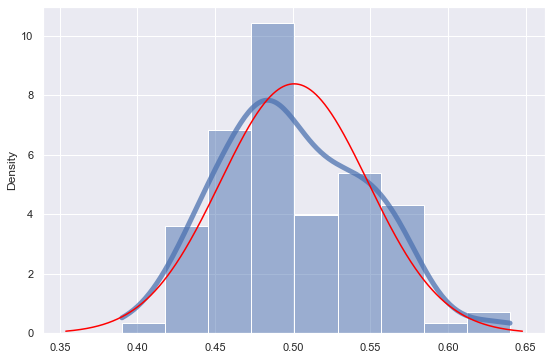

In [139]:
flip_coin(n_times=100)

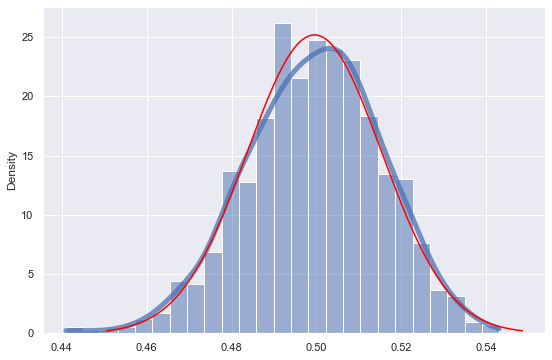

In [140]:
flip_coin(n_times=1000)

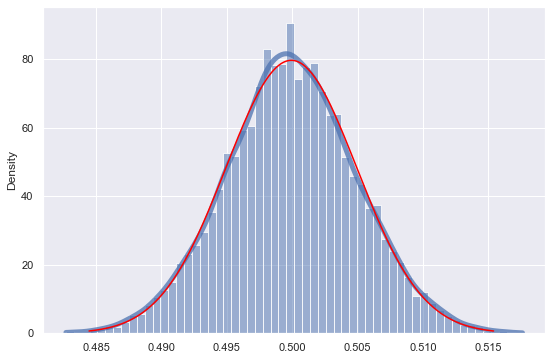

In [141]:
flip_coin(n_times=10_000)

***
### __Предельные теоремы для схемы Бернулли__

__Пример__. _Найти вероятность события $A$, заключающегося в том, что произошло не менее $k=5$ успехов в серии из $n=100$ испытаний по схеме Бернулли, где вероятность успеха в каждом испытании постоянна и равна $p=0,03$._

Посчитаем вычитанием из единицы вероятности противоположного события - вычтем в цикле последовательно вероятности ровно 0, 1, ..., 4 успехов, посчитанные последовательно: по формуле Бернулли вручную, как pmf биномиальной случайной величины __`scipy.stats.binom`__, по теореме Пуассона вручную, как pmf пуассоновской случайной величины __`scipy.stats.poisson`__, по локальной теореме Муавра-Лапласа:

In [126]:
n = 100
k = 5
p = .03

p_bernoulli_handm = p_bernoulli_stats = \
    p_poisson_handm = p_poisson_stats = \
        p_ml_loc = 1

rv_binom = stats.binom(n, p)
rv_poisson = stats.poisson(n*p)

for i in range(k):
    p_bernoulli_handm -= binom(n, i) * p**i * (1-p)**(n-i)
    p_bernoulli_stats -= rv_binom.pmf(i)
    p_poisson_handm -= (n*p)**i * np.exp(-n*p) / factorial(i)
    p_poisson_stats -= rv_poisson.pmf(i)
    p_ml_loc -= np.exp(-(i-n*p)**2/(2*n*p*(1-p))) / np.sqrt(2*np.pi*n*p*(1-p))

print(
    f'{p_bernoulli_handm=}\n'
    f'{p_bernoulli_stats=}\n'
    f'{p_poisson_handm=}\n'
    f'{p_poisson_stats=}\n'
    f'{p_ml_loc=}'
)

# p_bernoulli_handm=0.18214519392435996
# p_bernoulli_stats=0.1821451939243579
# p_poisson_handm=0.18473675547622792
# p_poisson_stats=0.1847367554762279
# p_ml_loc=0.2048119738911829

p_bernoulli_handm=0.18214519392435996
p_bernoulli_stats=0.1821451939243579
p_poisson_handm=0.18473675547622792
p_poisson_stats=0.1847367554762279
p_ml_loc=0.2048119738911829


Обратите внимание, что суммирование вероятностей по локальной теореме Муавра-Лапласа от 5 до 100 дает более точный результат:

In [127]:
p_ml_loc = 0

for i in range(k, n+1):
    p_ml_loc += np.exp(-(i-n*p)**2/(2*n*p*(1-p))) / np.sqrt(2*np.pi*n*p*(1-p))
    
p_ml_loc  # 0.1861240501530454

0.1861240501530454

Расчет по интегральной теореме Муавра-Лапласа с помощью [__`scipy.integrate.quad`__](https://scipy.github.io/devdocs/reference/generated/scipy.integrate.quad.html):

In [128]:
bound = lambda x: (x - n*p) / np.sqrt(n*p*(1-p))
Phi = lambda x: np.exp(-x**2/2)
p_ml_int = quad(Phi, bound(k), bound(n))[0] / np.sqrt(2*np.pi)
p_ml_int  # 0.120514083632216

0.120514083632216

***